In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd drive/My\ Drive

In [ ]:
%cd Colab\ Notebooks

We decided to implement a algorithm for ML that will help the system to predict a potential crowded place. In this particular case, we retrieved a dataset of a gym, that contains really informative data for our purpose. The goal is to learn from that dataset. 

The next lines will initialize our data, displaying the first 5 rows.

In [ ]:
# Import libraries necessary for this project
from __future__ import division
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames


# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("data.csv")

# Success - Display the first record
display(data.head())

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17


### Implementation: Data Exploration

- The total number of records, `n_records`
- The total number of alerts, `n_alerts`
- The total number of no alerts, `n_noalerts`


In [ ]:
n_records = len(data)

n_alerts = len(data[data['number_people'] > 30])

n_noalerts = len(data[data['number_people'] <= 30])

# Print the results
print("Total number of records: {}".format(n_records))
print("Alerts count: {}".format(n_alerts))
print("No Alerts count: {}".format(n_noalerts))

Total number of records: 62184
Alerts count: 28021
No Alerts count: 34163


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it has to be cleaned, formatted, and restructured — this is typically known as **preprocessing**.

first, we convert the field `number_people` in a binary variable, so if there are more than a certain threshold, we put 1 (*raise alert*) otherwise 0. For our system, it is ok to put this value to `30`.

In [ ]:
threshold = 30
data['number_people'] = np.where(data['number_people']>threshold, 1, 0)

display(data.head())

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,1,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,1,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,1,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,1,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,1,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17


now we can split features and target:
- features: the data from which we want to learn.
- targets: the data we want to predict. in this case, it is known a priori.

In [ ]:
targets = data['number_people']

features = data.drop('number_people', axis = 1)

Then, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution. However, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['timestamp', 'temperature', 'month', 'hour']

features_minmax_transform = pd.DataFrame(data = features)
features_minmax_transform[numerical] = scaler.fit_transform(features_minmax_transform[numerical])

display(features_minmax_transform.head())

,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,2015-08-14 17:00:11-07:00,0.708469,4,0,0,0.685703,0,0,0.636364,0.73913
1,2015-08-14 17:20:14-07:00,0.722393,4,0,0,0.685703,0,0,0.636364,0.73913
2,2015-08-14 17:30:15-07:00,0.729349,4,0,0,0.685703,0,0,0.636364,0.73913
3,2015-08-14 17:40:16-07:00,0.736305,4,0,0,0.685703,0,0,0.636364,0.73913
4,2015-08-14 17:50:17-07:00,0.743261,4,0,0,0.685703,0,0,0.636364,0.73913


no one hot encoding is needed for this dataset.

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features but `date`, because `timestamp` will be used instead, and all numerical features have been normalized. We will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [ ]:
# Import train_test_split
from sklearn.model_selection import train_test_split

final_features = features_minmax_transform.drop('date', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(final_features, 
                                                    targets, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 49747 samples.
Testing set has 12437 samples.


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    results['train_time'] = end - start
        
    start = time()
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time()

    results['pred_time'] = end - start
            
    results['acc_train'] = accuracy_score(predictions_train, y_train[:300])
        
    results['acc_test'] = accuracy_score(predictions_test, y_test)

    results['f_train'] = fbeta_score(predictions_train, y_train[:300], 1.0)
        
    results['f_test'] = fbeta_score(predictions_test, y_test, 1.0)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

For this kind of dataset, we chose a decision tree classifier, because of the entropy of some entries. In order to use the best possible hyperparameters, we used the GridSearch. For what concerns the scorer, fbeta with `beta=1` is a good tradeoff for both precision and recall. WE also included a accuracy score, in order to see the difference between the 2 scorers.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()

parameters = {
    'min_samples_split' : [2, 4, 6, 8, 10],
    'max_depth': [2,4,6,8,10]
}

scorer = make_scorer(fbeta_score, beta=1.0)

grid_obj = GridSearchCV(clf, parameters, scoring=scorer,n_jobs=10, verbose=10)

grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_
print(best_clf)
# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Batch computation too fast (0.1044s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    2.5s
[Parallel(n_jobs=10)]: Batch computation too slow (2.0130s.) Setting batch_size=1.
[Parallel(n_jobs=10)]: Done  62 tasks      | elapsed:    4.4s
[Parallel(n_jobs=10)]: Done  84 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done 105 tasks      | elapsed:    8.0s
[Parallel(n_jobs=10)]: Done 119 out of 125 | elapsed:    9.6s remaining:    0.5s
[Parallel(n_jobs=10)]: Done 125 out of 125 | elapsed:    9.8s finished


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Unoptimized model
------
Accuracy score on testing data: 0.8873
F-score on testing data: 0.8751

Optimized Model
------
Final accuracy score on the testing data: 0.8502
Final F-score on the testing data: 0.8224


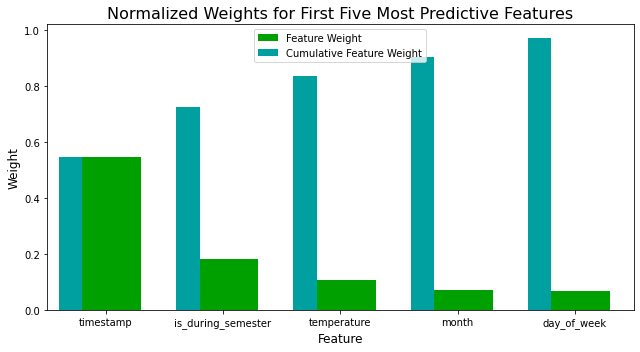

In [ ]:
importances = best_clf.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

as we can see, there are some columns that are informative, and other that are not. 

Now that we trained our model, we are free to feed it with new data and see the prediction, for example for a particular day in the future.